### NLP From Scratch: Classifying Names with a Character-Level RNN

**************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`

#### Print your name

In [1]:
## Your code here 
print("Exercise by: Janne Bragge")

Exercise by: Janne Bragge


We will be building and training a basic character-level RNN to classify
words. This tutorial, along with the following two, show how to do
preprocess data for NLP modeling "from scratch", in particular not using
many of the convenience functions of `torchtext`, so you can see how
preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <https://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [2]:
%matplotlib inline

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['../data/names/Portuguese.txt', '../data/names/English.txt', '../data/names/Vietnamese.txt', '../data/names/Finnish.txt', '../data/names/French.txt', '../data/names/Chinese.txt', '../data/names/German.txt', '../data/names/Polish.txt', '../data/names/Czech.txt', '../data/names/Arabic.txt', '../data/names/Dutch.txt', '../data/names/Russian.txt', '../data/names/Scottish.txt', '../data/names/Japanese.txt', '../data/names/Greek.txt', '../data/names/Korean.txt', '../data/names/Spanish.txt', '../data/names/Irish.txt', '../data/names/Italian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [4]:
finnish_names = (category_lines['Finnish'])
print(category_lines['Finnish'][:5])

['Aadan', 'Aakala', 'Aakko', 'Aakkula', 'Aakula']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [5]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [7]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [8]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8995, -2.9364, -2.9232, -3.0398, -2.9379, -2.8496, -3.0190, -2.9425,
         -3.0406, -3.0018, -2.8595, -2.9655, -2.8588, -2.9755, -2.9246, -3.0180,
         -2.9645, -2.9522, -2.8687]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 5)


We will also want a quick way to get a training example (a name and its
language):




In [10]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Trudu
category = English / line = Said
category = Dutch / line = Rompu
category = Scottish / line = Macleod
category = Finnish / line = Enasuo
category = English / line = Collingwood
category = Irish / line = Macfarland
category = English / line = Lange
category = Japanese / line = Koguchi
category = Polish / line = Michel


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [11]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [12]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [13]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Keep track of correct predictions
correct_count = 0

# Keep track of cumulative loss and iterations
total_loss = 0
total_iters = 0

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    total_loss += loss #update total loss
    total_iters += 1 #update total iters

    guess, guess_i = categoryFromOutput(output)
    if guess == category:
        correct_count += 1

    # Print iter number, cumulative average loss, name and guess
    if iter % print_every == 0:
        accuracy = correct_count / print_every  # Calculate accuracy
        cumulative_average_loss = total_loss / total_iters # Calculate cumulative average loss
        print('%d %d%% (%s) Loss: %.4f Accuracy: %.4f' % (iter, iter / n_iters * 100, timeSince(start), cumulative_average_loss, accuracy))
        correct_count = 0  # Reset correct count for the next interval


    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 43s) Loss: 2.8203 Accuracy: 0.2142
10000 10% (1m 27s) Loss: 2.6074 Accuracy: 0.2766
15000 15% (2m 10s) Loss: 2.4498 Accuracy: 0.3526
20000 20% (2m 54s) Loss: 2.3456 Accuracy: 0.3666
25000 25% (3m 37s) Loss: 2.2585 Accuracy: 0.4190
30000 30% (4m 21s) Loss: 2.1886 Accuracy: 0.4436
35000 35% (5m 5s) Loss: 2.1283 Accuracy: 0.4618
40000 40% (5m 48s) Loss: 2.0728 Accuracy: 0.4852
45000 45% (6m 32s) Loss: 2.0225 Accuracy: 0.5046
50000 50% (7m 17s) Loss: 1.9804 Accuracy: 0.5132
55000 55% (8m 0s) Loss: 1.9442 Accuracy: 0.5116
60000 60% (8m 43s) Loss: 1.9097 Accuracy: 0.5180
65000 65% (9m 26s) Loss: 1.8772 Accuracy: 0.5424
70000 70% (10m 10s) Loss: 1.8480 Accuracy: 0.5476
75000 75% (10m 53s) Loss: 1.8238 Accuracy: 0.5400
80000 80% (11m 36s) Loss: 1.8011 Accuracy: 0.5496
85000 85% (12m 20s) Loss: 1.7800 Accuracy: 0.5588
90000 90% (13m 3s) Loss: 1.7611 Accuracy: 0.5442
95000 95% (13m 46s) Loss: 1.7424 Accuracy: 0.5682
100000 100% (14m 30s) Loss: 1.7243 Accuracy: 0.5712


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




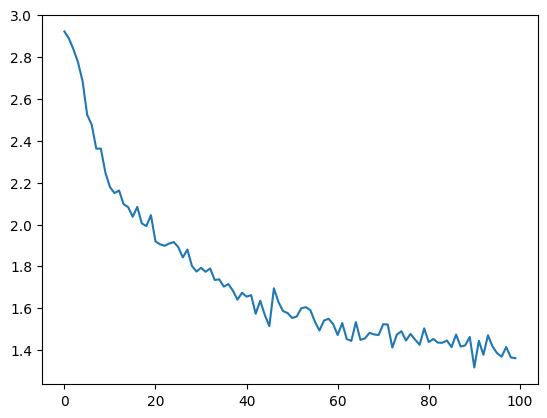

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




/tmp/ipykernel_301/3585656379.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_301/3585656379.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


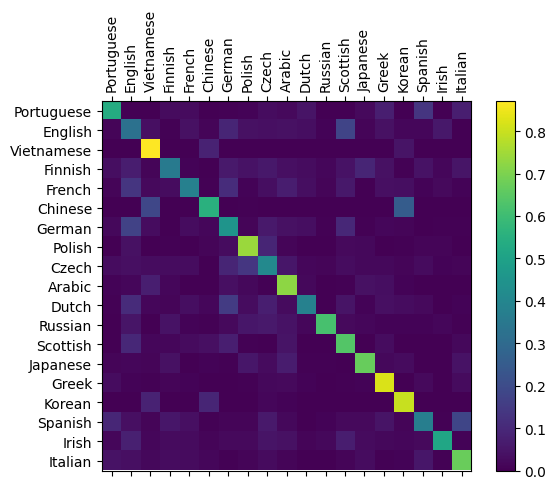

In [15]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [16]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.90) Czech
(-1.12) Russian
(-2.13) English

> Jackson
(-0.32) Scottish
(-1.67) English
(-3.69) Russian

> Satoshi
(-1.25) Arabic
(-1.40) Japanese
(-1.40) Polish


In [17]:
# Task 3

n_iters = 100000
print_every = 5000
#plot_every = 1000
n_hidden = 128

# --- Define the categories list ---
categories = all_categories

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# Keep track of correct predictions
correct_count = 0

# Keep track of cumulative loss and iterations
total_loss = 0
total_iters = 0

# --- Network Reinitialization ---
rnn = RNN(n_letters, n_hidden, len(categories)) # Käytetään len(categories) n_categories arvoon

# --- Training with 100,000 iterations ---
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    total_loss += loss
    total_iters += 1

    guess, guess_i = categoryFromOutput(output)
    #correct = '✓' if guess == category else '✗ (%s)' % category
    if guess == category:
        correct_count += 1

    if iter % print_every == 0:
        accuracy = correct_count / print_every
        cumulative_average_loss = total_loss / total_iters
        print('%d %d%% (%s) Loss: %.4f Accuracy: %.4f' % (iter, iter / n_iters * 100, timeSince(start), cumulative_average_loss, accuracy))
        correct_count = 0

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# --- Calculating Accuracy with Finnish Names ---
correct_finnish = 0
total_finnish = len(finnish_names)

with torch.no_grad():
    for name in finnish_names:
        line_tensor = lineToTensor(name)
        category_tensor = torch.tensor([categories.index('Finnish')], dtype=torch.long)
        # Alusta hidden state
        hidden = rnn.initHidden()
        # Käy läpi line_tensor kirjain kirjaimelta
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        guess, guess_i = categoryFromOutput(output)
        if guess == 'Finnish':
            correct_finnish += 1

accuracy = correct_finnish / total_finnish * 100
print(f'\n Accuracy with Finnish names: {accuracy:.2f}%')

# Muokattu train funktio
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

5000 5% (0m 43s) Loss: 2.8342 Accuracy: 0.1842
10000 10% (1m 26s) Loss: 2.6290 Accuracy: 0.2850
15000 15% (2m 10s) Loss: 2.4736 Accuracy: 0.3418
20000 20% (2m 54s) Loss: 2.3584 Accuracy: 0.3836
25000 25% (3m 37s) Loss: 2.2670 Accuracy: 0.4076
30000 30% (4m 21s) Loss: 2.1864 Accuracy: 0.4492
35000 35% (5m 4s) Loss: 2.1202 Accuracy: 0.4754
40000 40% (5m 47s) Loss: 2.0634 Accuracy: 0.4816
45000 45% (6m 31s) Loss: 2.0164 Accuracy: 0.5000
50000 50% (7m 14s) Loss: 1.9739 Accuracy: 0.5062
55000 55% (7m 57s) Loss: 1.9346 Accuracy: 0.5232
60000 60% (8m 40s) Loss: 1.8997 Accuracy: 0.5380
65000 65% (9m 24s) Loss: 1.8690 Accuracy: 0.5412
70000 70% (10m 8s) Loss: 1.8410 Accuracy: 0.5394
75000 75% (10m 51s) Loss: 1.8149 Accuracy: 0.5478
80000 80% (11m 35s) Loss: 1.7922 Accuracy: 0.5576
85000 85% (12m 18s) Loss: 1.7711 Accuracy: 0.5578
90000 90% (13m 1s) Loss: 1.7514 Accuracy: 0.5624
95000 95% (13m 45s) Loss: 1.7324 Accuracy: 0.5732
100000 100% (14m 28s) Loss: 1.7151 Accuracy: 0.5664

 Accuracy with 

In [19]:
predict('Bragge')
predict("Virtanen")
predict('Pulkkinen')


> Bragge
(-0.82) French
(-1.76) Italian
(-2.24) English

> Virtanen
(-1.07) Finnish
(-1.96) Dutch
(-2.18) English

> Pulkkinen
(-0.35) Finnish
(-2.13) Russian
(-3.15) English


# Reflection

1. How accurate neural network is?
2. How many % of Finnish names network predicts correctly as Finnish? 
3. Try your sur name. What neural netwoprk predicts?
4. What you could do to improve neural network performance? 

*Your answers here...*

1) Despite the network learning steadily, the accuracy remained at a rather modest level of approximately 50%. Based on the confusion matrix, names from certain countries are more distinguishable from those of other countries—this is the case with Vietnamese names, for example. Finnish names, on the other hand, achieve a relatively low level, which indicates the diversity of the names.

2) In the case of Finnish names, the network performed less efficiently than I expected, achieving only about 25% accuracy. This made me reflect on the reasons for this difference. I wondered if it was due to the unique features of the Finnish language, the diversity of Finnish names, or possibly the scarcity of training data for Finnish names.

3) For my own name, the strongest suggestion was French, even though my name was indeed found in the Finnish names list. However, the code doesn't directly check which list a name is from; instead, it makes predictions based on the name data. I also used some of the most typical Finnish names, for which the prediction was correct.

4)

* I would review the incorrectly predicted names to identify any common characteristics.

* I would adjust the model's hyperparameters and examine the effects of these changes on the model.

* I would perhaps develop the model further by adding the processing of first names, as the combination of first and last names could better identify the nationality behind the name. (more data)

* The model excluded special characters; I would consider whether I could utilize these in training and examine their impact on the current model.   



## Great job!